In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.json to test.json
Saving train.json to train.json


In [3]:
# ! apt-get install -y openjdk-8-jdk python3-dev
! pip install konlpy "tweepy<4.0.0"
# ! /bin/bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [4]:
!pip install transformers

     |████████████████████████████████| 5.3 MB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 163 kB 19.1 MB/s eta 0:00:01�████████████████          | 112 kB 19.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 13.5 MB/s eta 0:00:01


In [ ]:
# %pip install -q wandb

In [10]:
!pip install torchinfo
!pip install easydict
!pip install sklearn
!pip install matplotlib
!pip install torch

     |████████████████████████████████| 133.8 MB 115 kB/s  eta 0:00:01


# Requirments

## Import

In [11]:
import os
import random
import math
import csv
import json
from statistics import mean
from typing import List, Tuple, Dict, Any
import uuid

from tqdm.notebook import tqdm
from easydict import EasyDict as edict

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# import wandb

import torch
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from torchinfo import summary

from transformers import ElectraModel, ElectraTokenizer, ElectraForQuestionAnswering, AutoModelForQuestionAnswering, AutoTokenizer

In [12]:
for name in 'models', 'submissions':
    os.makedirs(name, exist_ok=True)

# Set Arguments, Hyper-parameters

In [ ]:
args = edict({'w_project': 'test_project',
              'w_entity': 'chohs1221',
              'learning_rate': 6e-5,
              'batch_size': {'train': 256,
                             'eval': 16,
                             'test': 256},
              'accumulate': 64,
              'epochs': 10,
              'seed': 42,
              # 'model_name': 'monologg/koelectra-base-v3-discriminator',
              'model_name': 'monologg/kobigbird-bert-base',
              'max_length': 4096})
# args['NAME'] = ''f'koelectra_ep{args.epochs}_lr{args.learning_rate}_{random.randrange(0, 1024)}'
args['NAME'] = ''f'kobigbird_ep{args.epochs}_max{args.max_length}_lr{args.learning_rate}_{random.randrange(0, 1024)}'
print(args.NAME)

# Initialize

## Wandb

In [ ]:
# wandb.login()

In [ ]:
# wandb.init(project = args.w_project, entity = args.w_entity)

In [ ]:
# wandb.run.name = args.NAME
# wandb.config.learning_rate = args.learning_rate
# wandb.config.epochs = args.epochs
# wandb.config.batch_size = args.batch_size

## Seed

In [15]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(args.seed)

## Tokenizer

In [16]:
# tokenizer = ElectraTokenizer.from_pretrained(args.model_name)
tokenizer = AutoTokenizer.from_pretrained(args.model_name)

Downloading:   0%|          | 0.00/373 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/241k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/169 [00:00<?, ?B/s]

## Model

In [17]:
# model = ElectraForQuestionAnswering.from_pretrained(args.model_name)
model = AutoModelForQuestionAnswering.from_pretrained(args.model_name)
# summary(model, (args.batch_size.train//args.accumulate, args.max_length), dtypes=['torch.IntTensor'], device='cpu')

Downloading:   0%|          | 0.00/870 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/458M [00:00<?, ?B/s]

Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdForQuestionAnswering: ['cls.predictions.transform.dense.weight', 'bert.pooler.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'bert.pooler.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of 

In [ ]:
model.cuda();

## Optimizer

In [19]:
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)

# Datasets

## Load, Split

In [133]:
class KoMRC:
    def __init__(self, data, indices: List[Tuple[int, int, int]]):
        self._data = data
        self._indices = indices


    # Json을 불러오는 메소드
    @classmethod
    def load(cls, file_path: str):
        with open(file_path, 'r', encoding='utf-8') as fd:
            data = json.load(fd)

        indices = []
        for d_id, document in enumerate(data['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))
        
        return cls(data, indices)


    # 데이터 셋을 잘라내는 메소드
    @classmethod
    def split(cls, dataset, eval_ratio: float=.1):
        indices = list(dataset._indices)
        random.shuffle(indices)
        train_indices = indices[int(len(indices) * eval_ratio):]
        eval_indices = indices[:int(len(indices) * eval_ratio)]

        return cls(dataset._data, train_indices), cls(dataset._data, eval_indices)


    def __getitem__(self, index: int) -> Dict[str, Any]:
        d_id, p_id, q_id = self._indices[index]
        paragraph = self._data['data'][d_id]['paragraphs'][p_id]

        qa = paragraph['qas'][q_id]

        guid = qa['guid']

        context = paragraph['context'].replace('\n', 'n').replace('\xad', '')

        question = qa['question'].replace('\n', 'n').replace('\xad', '')

        answers = qa['answers']
        if answers != None:
            for a in answers:
                a['text'] = a['text'].replace('\n', 'n').replace('\xad', '')

        # context = paragraph['context']
        #
        # question = qa['question']
        #
        # answers = qa['answers']


        return {'guid': guid,
            'context': context,
            'question': question,
            'answers': answers
        }

    def __len__(self) -> int:
        return len(self._indices)

In [134]:
# dataset = KoMRC.load('./datasets2/train.json')
dataset = KoMRC.load('train_added_aihub.json')
train_dataset, dev_dataset = KoMRC.split(dataset)
print("Number of Samples:", len(dataset))
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
# print(dataset[0])
# print(train_dataset[0])
# print(dev_dataset[0])

Number of Samples: 131741
Number of Train Samples: 118567
Number of Dev Samples: 13174


## Tokenize & Tag Token Positions

In [138]:
class TokenizedKoMRC(KoMRC):
    def __init__(self, data, indices: List[Tuple[int, int, int]]) -> None:
        super().__init__(data, indices)
        self._tokenizer = tokenizer


    def _tokenize_with_position(self, sentence: str) -> List[Tuple[str, Tuple[int, int]]]:
        position = 0
        tokens = []

        sentence_tokens = []
        for word in sentence.split():
            if '[UNK]' in tokenizer.tokenize(word):
                sentence_tokens.append(word)
            else:
                sentence_tokens += tokenizer.tokenize(word)
        
        for morph in sentence_tokens:
            if len(morph) > 2:
                if morph[:2] == '##':
                    morph = morph[2:]

            position = sentence.find(morph, position)
            tokens.append((morph, (position, position + len(morph))))
            position += len(morph)
            
        return tokens


    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = super().__getitem__(index)
        # sample = {'guid': guid, 'context': context, 'question': question, 'answers': answers}

        context, position = zip(*self._tokenize_with_position(sample['context']))
        context, position = list(context), list(position)

        question = self._tokenizer.tokenize(sample['question'])

        if sample['answers'] is not None:
            answers = []
            for answer in sample['answers']:
                for start, (position_start, position_end) in enumerate(position):
                    if position_start <= answer['answer_start'] < position_end:
                        break
                else:
                    print('position', position)
                    print('context', context)
                    print('origin_nal', sample['context'])
                    print('answer s', answer['answer_start'])
                    print('answer', answer)
                    print('guid', sample['guid'])
                    # print(answer['guid'])
                    # print(answer['answer_start'])
                    raise ValueError("No mathced start position")

                target = ''.join(answer['text'].split(' '))
                source = ''
                for end, morph in enumerate(context[start:], start):
                    source += morph
                    if target in source:
                        break
                else:
                    # print(context, answer)
                    print('position', position)
                    print('context', context)
                    print('context[start:]', context[start:])
                    print('answer', answer)
                    print('start', start)
                    print('guid', sample['guid'])
                    raise ValueError("No Matched end position")

                answers.append({'start': start, 'end': end})
                
        else:
            answers = None
        
        return {
            'guid': sample['guid'],
            'context_original': sample['context'],
            'context_position': position,
            'question_original': sample['question'],
            'context': context,
            'question': question,
            'answers': answers
        }

In [139]:
# dataset = TokenizedKoMRC.load('./datasets2/train.json')
dataset = TokenizedKoMRC.load('train_added_aihub.json')
train_dataset, dev_dataset = TokenizedKoMRC.split(dataset)
print("Number of Samples:", len(dataset))
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
# print(dataset[0])
# print(train_dataset[0])
# print(dev_dataset[0])

Number of Samples: 131739
Number of Train Samples: 118566
Number of Dev Samples: 13173


In [140]:
sample = dev_dataset[0]
print(sample['context'][sample['answers'][0]['start']:sample['answers'][0]['end']+1])

a = []
for i in train_dataset:
    if len(sample['context'] + sample['question']) > 2000:
        a.append(len(sample['context'] + sample['question']))

a

['새', '한', '티', '이', '피']


[]

## Input

In [125]:
class Indexer:
    def __init__(self, vocabs: List[str], max_length: int=args.max_length):
        self.max_length = max_length
        self.vocabs = vocabs

    @property
    def vocab_size(self):
        return len(self.vocabs)
    @property
    def pad_id(self):
        return tokenizer.vocab['[PAD]']
    @property
    def unk_id(self):
        return tokenizer.vocab['[UNK]']
    @property
    def cls_id(self):
        return tokenizer.vocab['[CLS]']
    @property
    def sep_id(self):
        return tokenizer.vocab['[SEP]']


    def sample2ids(self, sample: Dict[str, Any],) -> Dict[str, Any]:
        context = [tokenizer.convert_tokens_to_ids(token) for token in sample['context']]
        question = [tokenizer.convert_tokens_to_ids(token) for token in sample['question']]

        context = context[:self.max_length-len(question)-3]             # Truncate context
        
        input_ids = [self.cls_id] + question + [self.sep_id] + context + [self.sep_id]
        token_type_ids = [0] * (len(question) + 1) + [1] * (len(context) + 2)

        if sample['answers'] is not None:
            answer = sample['answers'][0]
            start = min(len(question) + 2 + answer['start'], self.max_length - 1)
            end = min(len(question) + 2 + answer['end'], self.max_length - 1)
        else:
            start = None
            end = None

        return {
            'guid': sample['guid'],
            'context': sample['context_original'],
            'question': sample['question_original'],
            'position': sample['context_position'],
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'start': start,
            'end': end
        }

In [126]:
indexer = Indexer(list(tokenizer.vocab.keys()))
# print(indexer.sample2ids(dev_dataset[0]))

## Attention Mask

In [127]:
class IndexerWrappedDataset:
    def __init__(self, dataset: TokenizedKoMRC, indexer: Indexer) -> None:
        self._dataset = dataset
        self._indexer = indexer

    def __len__(self) -> int:
        return len(self._dataset)
    
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = self._indexer.sample2ids(self._dataset[index])
        sample['attention_mask'] = [1] * len(sample['input_ids'])

        return sample

In [128]:
indexed_train_dataset = IndexerWrappedDataset(train_dataset, indexer)
indexed_dev_dataset = IndexerWrappedDataset(dev_dataset, indexer)

sample = indexed_dev_dataset[0]
# print('input_ids', sample['input_ids'])
# print('attention_mask', sample['attention_mask'])
# print('token_type_ids', sample['token_type_ids'])
# print('start', sample['start'])
# print('end', sample['end'])

## Collate

In [129]:
class Collator:
    def __init__(self, indexer: Indexer) -> None:
        self._indexer = indexer


    def __call__(self, samples: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        samples = {key: [sample[key] for sample in samples] for key in samples[0]}

        for key in 'start', 'end':
            if samples[key][0] is None:
                samples[key] = None
            else:
                samples[key] = torch.tensor(samples[key], dtype=torch.long)
        
        for key in 'input_ids', 'attention_mask', 'token_type_ids':
            samples[key] = pad_sequence([torch.tensor(sample, dtype=torch.long) for sample in samples[key]],
                                        batch_first=True,
                                        padding_value=self._indexer.pad_id)

        return samples

## Data Loader

In [130]:
collator = Collator(indexer)
train_loader = DataLoader(indexed_train_dataset,
                          batch_size = args.batch_size.train // args.accumulate,
                          shuffle = True,
                          collate_fn = collator,
                          num_workers = 2)

dev_loader = DataLoader(indexed_dev_dataset,
                        batch_size = args.batch_size.eval,
                        shuffle = False,
                        collate_fn = collator,
                        num_workers = 2)

In [131]:
batch = next(iter(dev_loader))
print(batch['input_ids'])
print(batch['input_ids'].shape)
print(list(batch.keys()))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ijinseong/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/ijinseong/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'IndexerWrappedDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

# Train

## Empty Cuda Cache

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Train

In [ ]:
train_losses = []
dev_losses = []

train_loss = []
dev_loss = []

loss_accumulate = 0.

best_model = [-1, int(1e9)]

for epoch in range(args.epochs):
    print("Epoch", epoch, '===============================================================================================================')

    # Train    
    progress_bar_train = tqdm(train_loader, desc='Train')
    for i, batch in enumerate(progress_bar_train, 1):
        del batch['guid'], batch['context'], batch['question'], batch['position']
        batch = {key: value.cuda() for key, value in batch.items()}
        
        start = batch.pop('start')
        end = batch.pop('end')
        
        output = model(**batch)

        start_logits = output.start_logits
        end_logits = output.end_logits
        
        loss = (F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)) / args.accumulate
        loss.backward()

        loss_accumulate += loss.item()

        del batch, start, end, start_logits, end_logits, loss
        
        if i % args.accumulate == 0:
            # clip_grad_norm_(model.parameters(), max_norm=1.)
            optimizer.step()
            optimizer.zero_grad(set_to_none=False)

            train_loss.append(loss_accumulate)
            progress_bar_train.set_description(f"Train - Loss: {loss_accumulate:.3f}")
            loss_accumulate = 0.
        else:
            continue

        if i % int(len(train_loader) / (args.accumulate * 25)) == 0:
            # Evaluation
            for batch in dev_loader:
                del batch['guid'], batch['context'], batch['question'], batch['position']
                batch = {key: value.cuda() for key, value in batch.items()}

                start = batch.pop('start')
                end = batch.pop('end')
                
                model.eval()
                with torch.no_grad():
                    output = model(**batch)
                
                    start_logits = output.start_logits
                    end_logits = output.end_logits
                model.train()

                loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)

                dev_loss.append(loss.item())

                del batch, start, end, start_logits, end_logits, loss

            train_losses.append(mean(train_loss))
            dev_losses.append(mean(dev_loss))
            train_loss = []
            dev_loss = []

            
            if dev_losses[-1] <= best_model[1]:
                best_model = (epoch, dev_losses[-1])
                model.save_pretrained(f'models/{args.NAME}_{epoch}')
                # print(f'model saved!!\nvalid_loss: {dev_losses[-1]}')
                
            # wandb.log({"train_loss": train_losses[-1],
                      #  "valid_loss": dev_losses[-1]})
            

    print(f"Train Loss: {train_losses[-1]:.3f}")
    print(f"Valid Loss: {dev_losses[-1]:.3f}")
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')


Epoch 0 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/big_bird/modeling_big_bird.py:982: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  * num_indices_to_pick_from
Attention type 'block_sparse' is not possible if sequence_length: 657 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Train Loss: 3.206
Valid Loss: 3.222
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 1 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

Train Loss: 2.166
Valid Loss: 2.477
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 2 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

Train Loss: 1.558
Valid Loss: 2.427
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 3 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

Train Loss: 1.079
Valid Loss: 2.688
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 4 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

Train Loss: 0.792
Valid Loss: 3.044
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 5 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

Train Loss: 0.520
Valid Loss: 3.439
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 6 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

Train Loss: 0.390
Valid Loss: 3.582
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 7 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

Train Loss: 0.295
Valid Loss: 3.844
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 8 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

Train Loss: 0.166
Valid Loss: 4.039
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Epoch 9 ===============================================================================================================


Train:   0%|          | 0/2709 [00:00<?, ?it/s]

Train Loss: 0.233
Valid Loss: 4.148
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


## Visualize Training

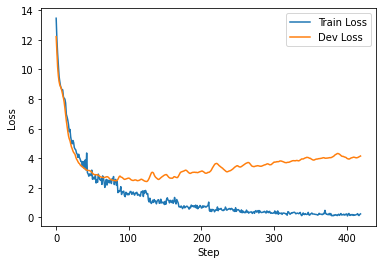

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(dev_losses, label="Dev Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test

## Datasets

In [ ]:
test_dataset = TokenizedKoMRC.load('/content/test.json')
# test_dataset = TokenizedKoMRC.load('./datasets2/test.json')
indexer_test = Indexer(list(tokenizer.vocab.keys()))
indexed_test_dataset = IndexerWrappedDataset(test_dataset, indexer_test)
print("Number of Test Samples", len(test_dataset))
# print(test_dataset[0])

Number of Test Samples 4008


## Model

In [ ]:
best_model[0]

2

In [ ]:
best_model

(2, 2.424068876787236)

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(f'models/{args.NAME}_{best_model[0]}')
model.cuda();
# summary(model, (args.batch_size.train//args.accumulate, args.max_length), dtypes=['torch.IntTensor'], device='cpu')

In [ ]:
for idx, sample in zip(range(1, 4), indexed_train_dataset):
    print(f'------{idx}------')
    print('Context:', sample['context'])
    print('Question:', sample['question'])
    
    input_ids, token_type_ids = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids")
    ]
    
    model.eval()
    with torch.no_grad():
        output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

    start_logits = output.start_logits
    end_logits = output.end_logits
    start_logits.squeeze_(0), end_logits.squeeze_(0)
    
    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

    index = torch.argmax(probability).item()
    
    start = index // len(end_prob)
    end = index % len(end_prob)
    
    start_str = sample['position'][start][0]
    end_str = sample['position'][end][1]

    print('Answer:', sample['context'][start_str:end_str])

Attention type 'block_sparse' is not possible if sequence_length: 483 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


------1------
Context: 1조3000억원에 달하는 사기성 기업어음(CP)을 발행해 투자자들에게 손해를 끼친 혐의 등으로 기소된 현재현 동양그룹 회장(65·사진)에게 징역 12년형이 선고됐다. 이는 역대 형사재판에 넘겨진 재벌 총수 중 두 번째로 무거운 형이다.서울중앙지법 형사합의25부(부장판사 위현석)는 17일 오후 열린 현 회장에 대한 선고 공판에서 “피해자가 4만명에 달하고 피해 금액도 유례를 찾아보기 힘든 대규모 기업범죄로 엄중한 책임을 묻지 않을 수 없다”며 이같이 선고했다. 함께 기소된 정진석 전 동양증권 사장은 징역 5년을, 김철 전 동양네트웍스 대표와 이상화 전 동양인터내셔널 대표는 각각 징역 4년과 3년6월을 선고받았다. 검찰은 앞서 현 회장에게 징역 15년형을 구형했다.재판부는 현 회장에게 적용된 1조2985억원의 사기성 CP 등 발행 혐의와 141억원대 횡령 혐의를 유죄로 판단했다. 재판부는 “피고인들은 CP 발행 당시 자력으로 만기상환하는 것은 불가능하다는 점을 알고 있었다”며 “현 회장은 그룹의 지배구조에 집착한 나머지 일반투자자를 상대로 기망적 수단과 방법을 동원해 CP와 회사채를 발행했다”고 지적했다. 이어 “이로 인해 경영과 아무런 관계가 없는 다수의 피해자가 막대한 경제적·정신적 피해를 입었다”며 “범행을 부인하며 반성하지 않고, 피해 회복을 위한 노력도 하지 않아 중형을 선고하지 않을 수 없다”고 말했다. 다만 시세조종 혐의와 6000억원대 배임 혐의에 대해서는 일부 유죄로, 회계 부정과 허위 재무제표 공시 혐의는 무죄로 판단했다.현 회장이 받은 징역 12년형은 역대 형사재판에 넘겨진 재벌 총수 중 두 번째로 높은 형이다. 최고형은 1997년 한보사태 때 정태수 전 한보그룹 회장이 받은 징역 15년형이다.
Question: 재벌총수 중 지금까지 가장 높은 형량을 받은 사람의 이름은?
Answer: 정태수
------2------
Context: 제닉스 스튜디오(대표 이일희)는 블록체인 기반 IoT 플랫폼 ‘젠서(x

## Evaluate

In [ ]:
start_visualize = []
end_visualize = []

with torch.no_grad(), open(f'submissions/{args.NAME}.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Id', 'Predicted'])

    rows = []
    c = 0
    # for sample in tqdm(test_dataset, "Testing"):
    for sample in tqdm(indexed_test_dataset, "Testing"):
        input_ids, token_type_ids = [torch.tensor(sample[key], dtype=torch.long, device="cuda") for key in ("input_ids", "token_type_ids")]
        # print(sample)
    
        model.eval()
        with torch.no_grad():
            output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

        start_logits = output.start_logits
        end_logits = output.end_logits
        start_logits.squeeze_(0), end_logits.squeeze_(0)

        start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
        end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

        probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

        # 토큰 길이 8까지만
        for row in range(len(start_prob) - 8):
            probability[row] = torch.cat((probability[row][:8+row].cpu(), torch.Tensor([0] * (len(start_prob)-(8+row))).cpu()), 0)

        index = torch.argmax(probability).item()

        start = index // len(end_prob)
        end = index % len(end_prob)
        
        # 확률 너무 낮으면 자르기
        if start_prob[start] > 0.3 and end_prob[end] > 0.3:
            start_str = sample['position'][start][0]
            end_str = sample['position'][end][1]
        else:
            start_str = 0
            end_str = 0

        start_visualize.append((list(start_prob.cpu()), (start, end), (start_str, end_str)))
        end_visualize.append((list(end_prob.cpu()), (start, end), (start_str, end_str)))
        
        rows.append([sample["guid"], sample['context'][start_str:end_str]])

    writer.writerows(rows)

Testing:   0%|          | 0/4008 [00:00<?, ?it/s]

## Visualize Evaluation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


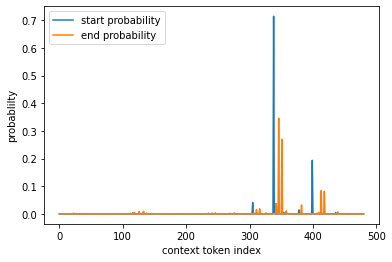

token position: (338, 342)
context position: (0, 0)


In [ ]:
idx = 0

start_visualize = np.array(start_visualize)
end_visualize = np.array(end_visualize)

start_probalilities, token_pos, str_pos = start_visualize[:,0], start_visualize[:,1], start_visualize[:,2]
end_probalilities, token_pos, str_pos = end_visualize[:,0], end_visualize[:,1], end_visualize[:,2]

plt.plot(start_probalilities[idx], label="start probability")
plt.plot(end_probalilities[idx], label="end probability")
plt.xlabel("context token index")
plt.ylabel("probablilty")
plt.legend()
plt.show()

print('token position:', token_pos[idx])
print('context position:', str_pos[idx])

1 294 298


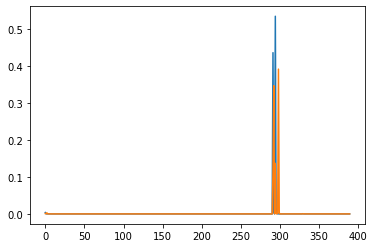

In [ ]:
for i, (start, end) in enumerate(token_pos):
    if end - start > 1:
        if i > 0:
            plt.plot(start_probalilities[i])
            plt.plot(end_probalilities[i])
            print(i, start, end)
            break

2.2043413173652695


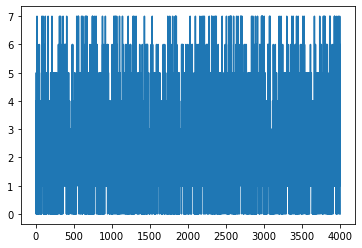

In [ ]:
temp = []
h = 0
l = 100
for i, (start, end) in enumerate(token_pos):
    h = max(h, end - start)
    l = min(l ,end - start)
    temp.append(end - start)
plt.plot(temp)
print(mean(temp))

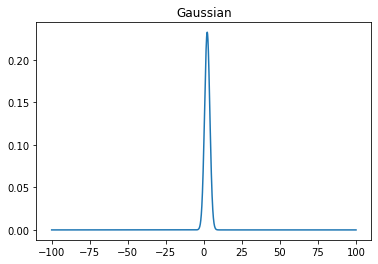

In [ ]:
mu = mean(temp)
sigma = math.sqrt(np.var(temp))
x = np.linspace(-100, 100, len(temp))
g = (1 / np.sqrt(2*np.pi * sigma**2)) * np.exp(- (x-mu)**2 / (2*sigma**2))
plt.title('Gaussian')
plt.plot(x, g)

In [ ]:
z = [(i-mu)/sigma for i in temp]
print(f'평균: {round(mean(z), 9)}')
print(f'표준편차: {math.sqrt(np.var(z))}')
print('-----90%------')
print(mu - 1.645*sigma/math.sqrt(len(temp)))
print(mu + 1.645*sigma/math.sqrt(len(temp)))
print('-----95%------')
print(mu - 1.96*sigma/math.sqrt(len(temp)))
print(mu + 1.96*sigma/math.sqrt(len(temp)))
print('-----99%------')
print(mu - 2.576*sigma/math.sqrt(len(temp)))
print(mu + 2.576*sigma/math.sqrt(len(temp)))

평균: -0.0
표준편차: 0.9999999999999999
-----90%------
2.1597466386515545
2.2489359960789845
-----95%------
2.151207232089354
2.257475402641185
-----99%------
2.1345079481454947
2.2741746865850443


In [ ]:
def read_dev_klue(path):
    with open(path, 'rb') as f:
        klue_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in tqdm(klue_dict['data']):
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                temp_answer = []
                for answer in qa['answers']:
                    temp_answer.append(answer['text'])
                if len(temp_answer) != 0: # answers의 길이가 0 == 답변할 수 없는 질문
                    contexts.append(context)
                    questions.append(question)
                    answers.append(temp_answer)

    return contexts, questions, answers

In [ ]:
dev_contexts, dev_questions, dev_answers = read_dev_klue("/content/klue-mrc-v1.1_dev.json")

  0%|          | 0/5075 [00:00<?, ?it/s]

In [ ]:
def prediction(contexts, questions):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    model.to(device)
    model.eval()
    
    result = []
    
    with torch.no_grad():
        for context, question in zip(contexts, questions):
            encodings = tokenizer(context, question, max_length=512, truncation=True,
                                     padding="max_length", return_token_type_ids=False)
            encodings = {key: torch.tensor([val]) for key, val in encodings.items()}
            
            input_ids = encodings["input_ids"].to(device)
            attention_mask = encodings["attention_mask"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            start_logits, end_logits = outputs.start_logits, outputs.end_logits
            token_start_index, token_end_index = start_logits.argmax(dim=-1), end_logits.argmax(dim=-1)
            pred_ids = input_ids[0][token_start_index: token_end_index + 1]
            pred = tokenizer.decode(pred_ids)
            result.append(pred)

    return result

In [ ]:
pred_answers = prediction(dev_contexts, dev_questions)
pred_answers

['말라카이트',
 '?',
 '5위',
 '5위',
 '?',
 '?',
 '',
 '?',
 '실리콘유로 만들기 위해 거치는 과정',
 '어디',
 '제품 수',
 '',
 '?',
 '16일',
 '?',
 '성서를 영어로 번역한 인물에게 영향을 받은 사람은?',
 '',
 '8호선 역',
 '',
 '한국예술영재교육원',
 '허벅지까지 내려오는 미들 기장의 다운 자켓',
 '어느 섬',
 '시장의 국적은?',
 '친구의 아내에게 함께 복수하기를 부탁하며 무엇',
 '',
 '',
 '',
 '현생 양서류의 호흡방식을 이용해 몸 밖으로 내보낼 수 있는 것은?',
 '',
 '무엇이라고',
 '무엇인가?',
 '',
 '남산 전망을 구경할 수 있는 아파트 이름은?',
 '무엇',
 '?',
 '',
 '올해보다 얼마나',
 '독일의 선거가 시작되는날',
 '어디',
 '어느 나라',
 '',
 '튀코 브라헤',
 '어디',
 '아리스타르코스',
 '?',
 '몇 편',
 '단순포진 각막염의 흰색 병변은 심한 경우에 무엇을 일으키나요?',
 '',
 '얼마',
 '교황청의 세력',
 '견과류',
 '어떤 호르몬을 투여하는 것',
 '?',
 '지구상의 연방군이 쓸 수 없게 된 것',
 '화학무기',
 '군함',
 '?',
 '붉은 혜성이라 부르는 인물',
 '',
 '코오롱프로세스시스템의 지분 절반 이상을 가지고 있는 회사는 어디인가?',
 '한국관광공사 소속 직원',
 '?',
 '?',
 '몇 개인',
 '무담보 대출금액',
 '',
 '?',
 '몇년도',
 '',
 '?',
 '어디',
 '물질',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '',
 '22일 발표된 내용의 조사 마감일',
 '?',
 '',
 '?',
 '',
 '얼마',
 '코나아이에서 스마트카드 개발팀장으로 근무했던 사람의 이름은?',
 '살던 곳',
 '몇 단계',
 '디오게네스는 누구',
 '',
 '일제강점기',
 '고종 황제를 폐위시킨 이후

In [ ]:
def em_evalutate(prediction_answers, real_answers):
    total = len(prediction_answers)
    exact_match = 0
    for prediction_answer, real_answer in zip(prediction_answers, real_answers):
        if prediction_answer in real_answer:
            exact_match += 1
    
    return (exact_match/total) * 100

In [ ]:
em_score = em_evalutate(pred_answers, dev_answers)
em_score

0.024950099800399198